In [1]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMModel,LGBMClassifier, plot_importance
from sklearn.metrics import classification_report

# Create the Dataframes test_data and train_data of the respective data sets.
test_data = pd.read_csv('https://raw.githubusercontent.com/vgorrepa/Big_Data_Final_Project/main/drugsComTest_raw.csv')
train_data = pd.read_csv('https://raw.githubusercontent.com/vgorrepa/Big_Data_Final_Project/main/drugsComTrain_raw.csv')

# Get header information for train_data
train_data.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [2]:
# Get header information for test_data
test_data.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [3]:
print("Train shape :" ,train_data.shape)
print("Test shape :", test_data.shape)
print("Train Set / Test Set", train_data.values.shape[0]/test_data.values.shape[0])

Train shape : (161297, 7)
Test shape : (53766, 7)
Train Set / Test Set 2.999981400885318


 Here it can be seen that the both the Train and Test Data sets have 6 variables and 1 unique id 
 Train Data set is ~ 3 times larger than the Test Data set.

In [4]:
test_data.dtypes


uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [5]:
train_data.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object



**Data Overview**
A patient with a unique ID purchases a drug that meets his or her condition and subsequently writes a review, provides a rating for the drug he/she purchased on the date. later on, if the other users read that review and find it helpful, they will click usefulCount, which will add 1 for the variable hence increasing the usefulCount.

**Data Types**
drugName (categorical): name of the drug
condition (categorical): name of the condition
review (text): patient's review
rating (numerical): 10 star patient's rating
date (date): date of review entry
usefulCount (numerical): number of users who found review useful


In [6]:
## Merging the Data
# As can be observed from the above analysis both the dataset contains same columns hence we can combine them for better analysis

data = pd.concat([train_data, test_data])
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [7]:
conditions = data.condition.value_counts().sort_values(ascending=False)
conditions[:15]

Birth Control                38436
Depression                   12164
Pain                          8245
Anxiety                       7812
Acne                          7435
Bipolar Disorde               5604
Insomnia                      4904
Weight Loss                   4857
Obesity                       4757
ADHD                          4509
Diabetes, Type 2              3362
Emergency Contraception       3290
High Blood Pressure           3104
Vaginal Yeast Infection       3085
Abnormal Uterine Bleeding     2744
Name: condition, dtype: int64

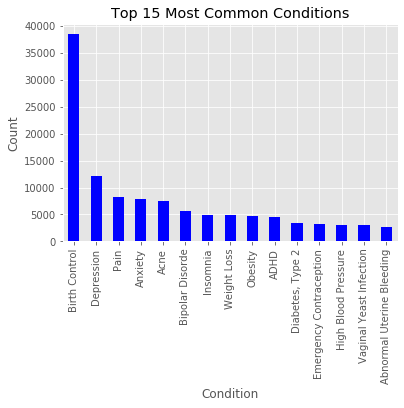

In [8]:
conditions[:15].plot(kind='bar',color ='blue')
plt.title('Top 15 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');

Text(0.5, 1.0, 'Count of rating values Data')

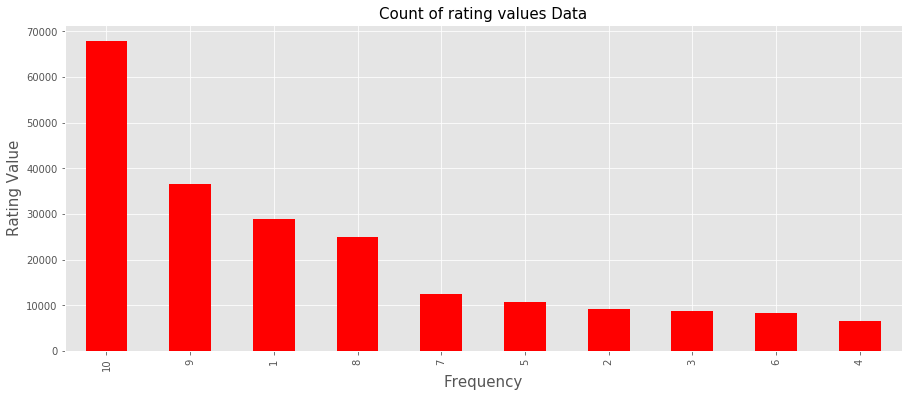

In [9]:
rating =data['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (15,6), fontsize = 10,color="red")
plt.xlabel("Frequency", fontsize = 15)
plt.ylabel("Rating Value", fontsize = 15)
plt.title("Count of rating values Data", fontsize = 15)

Comparing the histograms of the ratings it can be deduced that the users giving ratings and reviews are mostly either very satisfied (10,9) or highly unsatisfied (1,2).



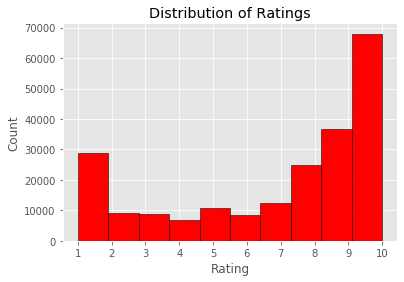

In [10]:
data.rating.hist(color='red',ec='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)]);

Text(0, 0.5, 'Count')

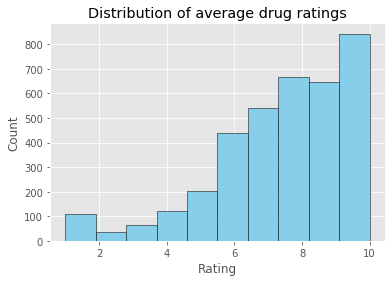

In [11]:
rating_avgs = (data['rating'].groupby(data['drugName']).mean())
rating_avgs.hist(color='skyblue',ec='black')
plt.title('Distribution of average drug ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

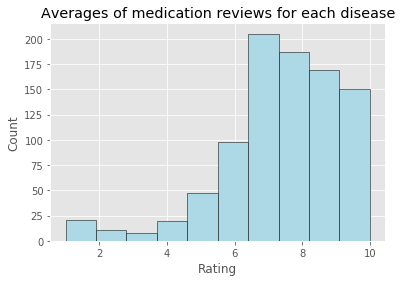

In [12]:
rating_avgs = (data['rating'].groupby(data['condition']).mean())
rating_avgs.hist(color='lightblue',ec='black')
plt.title('Averages of medication reviews for each disease')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [13]:
# describing the data

data.describe()

,uniqueID,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [14]:
# taking out information from the data

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
uniqueID       215063 non-null int64
drugName       215063 non-null object
condition      213869 non-null object
review         215063 non-null object
rating         215063 non-null int64
date           215063 non-null object
usefulCount    215063 non-null int64
dtypes: int64(3), object(4)
memory usage: 18.1+ MB


In [15]:
# checking if the data contains any NULL values

data.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

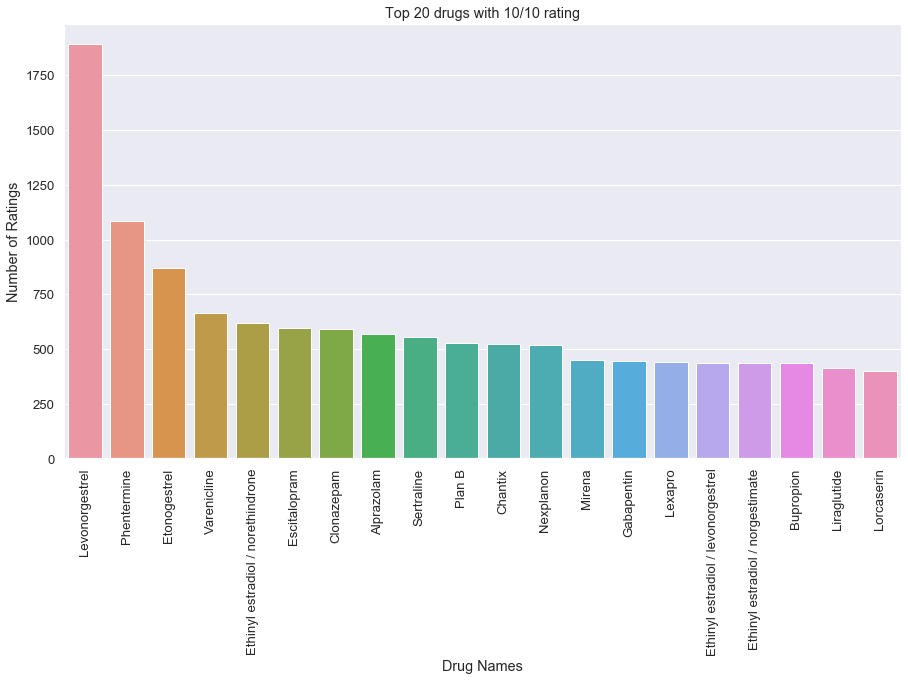

In [16]:
# This barplot shows the top 20 drugs with the 10/10 rating

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(data.loc[data.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

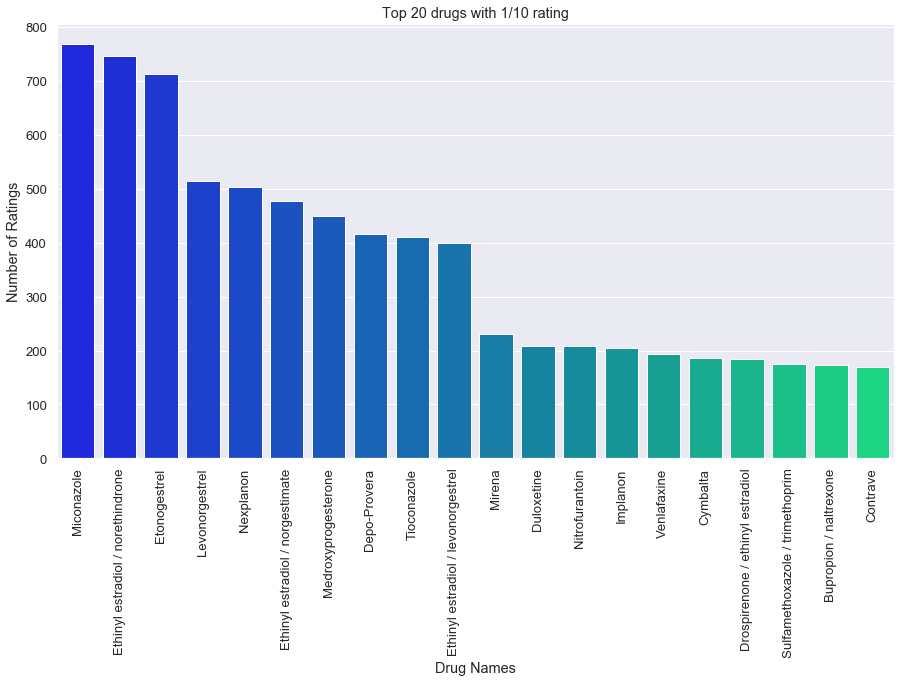

In [17]:
# This barplot shows the Top 20 drugs with the 1/10 rating

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(data.loc[data.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

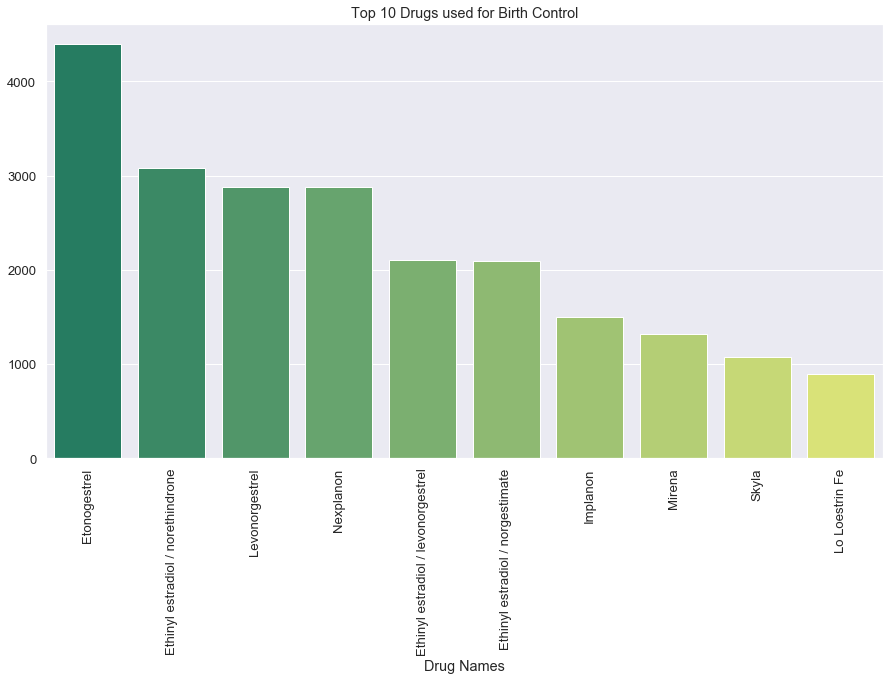

In [18]:
# Top 10 drugs which are used for the top condition, that is Birth Control
df1 = data[data['condition'] == 'Birth Control']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

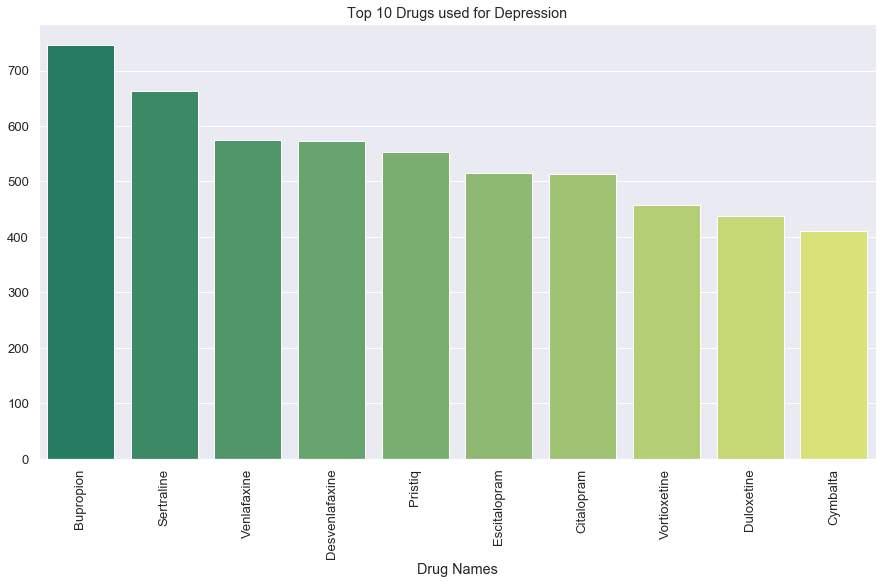

In [19]:
# Top 10 drugs which are used for the top condition, that is Birth Control
df1 = data[data['condition'] == 'Depression']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Depression")
plt.setp(sns_.get_xticklabels(), rotation = 90);

In [20]:
# feature engineering 
# let's make a new column review sentiment 

data.loc[(data['rating'] >= 5), 'Review_Sentiment'] = 1
data.loc[(data['rating'] < 5), 'Review_Sentiment'] = 0

data['Review_Sentiment'].value_counts()

1.0    161491
0.0     53572
Name: Review_Sentiment, dtype: int64

In [21]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 8 columns):
uniqueID            215063 non-null int64
drugName            215063 non-null object
condition           213869 non-null object
review              215063 non-null object
rating              215063 non-null int64
date                215063 non-null object
usefulCount         215063 non-null int64
Review_Sentiment    215063 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 19.8+ MB


In [22]:
data.loc[(data['rating'] >= 5), 'Review_Sentiment'] = 1
data.loc[(data['rating'] < 5), 'Review_Sentiment'] = 0

data['Review_Sentiment'].value_counts()

1.0    161491
0.0     53572
Name: Review_Sentiment, dtype: int64

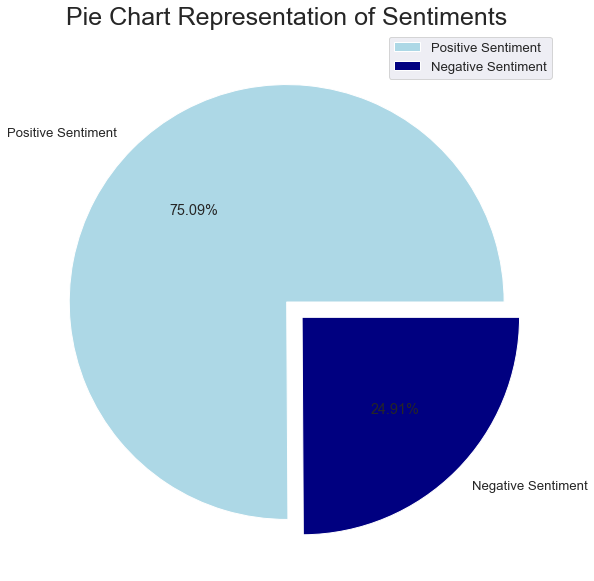

In [23]:
# A pie chart to represent the sentiments of the patients

size = [161491, 53572]
colors = ['lightblue', 'navy']
labels = "Positive Sentiment","Negative Sentiment"
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, explode = explode, autopct = '%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Sentiments', fontsize = 25)
plt.legend()
plt.show()

 Usefulness vs Rating

([<matplotlib.axis.XTick at 0x255c11f7688>,
 <a list of 10 Text xticklabel objects>)

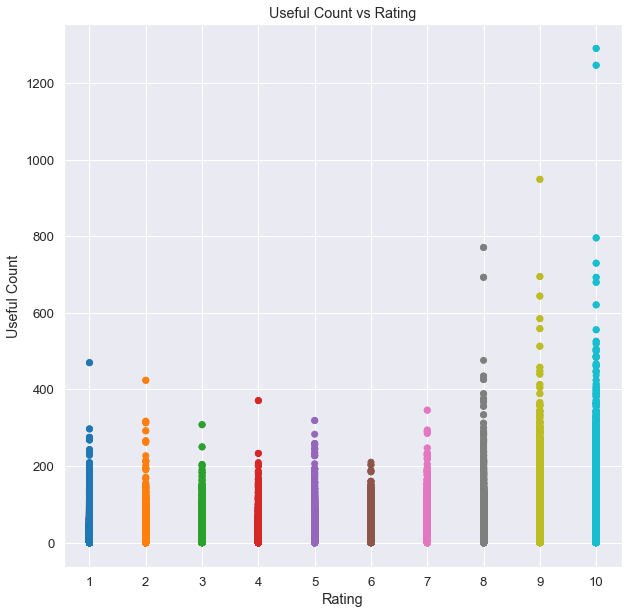

In [24]:
# Is rating correlated with usefulness of the review?
plt.scatter(data.rating, data.usefulCount, c=data.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 11)])

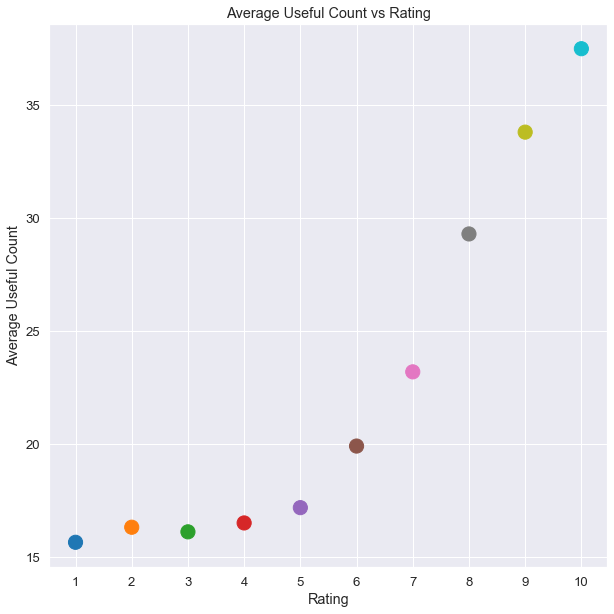

In [25]:
# Create a list (cast into an array) containing the average usefulness for given ratings

use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(data[data.rating == i].usefulCount) / np.sum([data.rating == i])])
    
use_arr = np.asarray(use_ls)
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 11)]);

# Machine Learning Models

1) The Naive Bayes Classifier
2) Logistic Regression

In [26]:
#The Naive Bayes classifier.

# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
x_review = vectorizer.fit_transform(data.review)

# Create a column with binary rating indicating the polarity of a review

data['Review_Sentiment']
y_rating = data.Review_Sentiment

x_train, x_test, y_train, y_test = train_test_split(x_review, y_rating, test_size=0.2, random_state=10)
x_review.shape, y_rating.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape


((215063, 53558),
 (215063,),
 (172050, 53558),
 (172050,),
 (43013, 53558),
 (43013,))

In [27]:
 
clf = MultinomialNB().fit(x_train, y_train)

# Evaluates model on test set

y_pred = clf.predict(x_test)


print("Accuracy on training set: {}".format(clf.score(x_train, y_train)))
print("Accuracy on test set: {}".format(clf.score(x_test, y_test)))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on training set: 0.7791688462656204
Accuracy on test set: 0.7748587636296004
Confusion Matrix
[[ 1073  9570]
 [  114 32256]]
              precision    recall  f1-score   support

         0.0       0.90      0.10      0.18     10643
         1.0       0.77      1.00      0.87     32370

    accuracy                           0.77     43013
   macro avg       0.84      0.55      0.53     43013
weighted avg       0.80      0.77      0.70     43013



In [28]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2', C=100,max_iter=10000).fit(x_train, y_train)

y_pred = clf_lr.predict(x_test)

print("Accuracy on training set: {}".format(clf_lr.score(x_train, y_train)))
print("Accuracy on test set: {}".format(clf_lr.score(x_test, y_test)))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on training set: 0.9343156059285092
Accuracy on test set: 0.8840815567386604
Confusion Matrix
[[ 7753  2890]
 [ 2096 30274]]
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76     10643
         1.0       0.91      0.94      0.92     32370

    accuracy                           0.88     43013
   macro avg       0.85      0.83      0.84     43013
weighted avg       0.88      0.88      0.88     43013

